In [29]:
import os
import mne
import pandas as pd
import numpy as np

from collections import defaultdict

import functions.utils as utils
import functions.io as io
import functions.preprocessing as preprocessing

# 1. Set the path and load the EEG preprocessed file

In [2]:
# Session to preprocess
session_id = "sub023 DBS ON mSST"
sub = session_id.split(' ') [0]
condition = session_id.split(' ') [1] + ' ' + session_id.split(' ') [2]

working_path = os.path.dirname(os.getcwd())
onedrive_path = utils._get_onedrive_path()

sub_onedrive_path_task = os.path.join(onedrive_path, sub, 'synced_data', session_id)

#  Set saving and source paths
results_path = os.path.join(working_path, "results")
saving_path = os.path.join(results_path, session_id)
source_path = os.path.join(saving_path, "sub_data", f"{sub}", "data")
file_p = os.path.join(source_path, f"{sub}_postICA_EEGdata_eeg.fif")

# Load fif file
raw = mne.io.read_raw_fif(file_p, preload=True)

Opening raw data file c:\Users\Juliette\Research\Projects\analysis_mSST\results\sub023 DBS ON mSST\sub_data\sub023\data\sub023_postICA_EEGdata_eeg.fif...
    Range : 0 ... 2557341 =      0.000 ...  1248.713 secs
Ready.
Reading 0 ... 2557341  =      0.000 ...  1248.713 secs...


In [4]:
# Inspect file
raw

<Raw | sub023_postICA_EEGdata_eeg.fif, 34 x 2557342 (1248.7 s), ~663.4 MB, data loaded>

# Load the corresponding behavioral file and generate epochs

In [ ]:
behav_session_data_path = os.path.join(
        onedrive_path, sub, "raw_data", 'BEHAVIOR', condition, 'mSST'
        )
for filename in os.listdir(behav_session_data_path):
        if filename.endswith(".csv"):
            fname = filename
filepath_behav = os.path.join(behav_session_data_path, fname)
df = pd.read_csv(filepath_behav)

# Crop dataframe in 2 parts: before and after the task:
# return the index of the first row which is not filled by a Nan value:
start_task_index = df['blocks.thisRepN'].first_valid_index()
df_maintask = df.iloc[start_task_index:-1]

Number of early presses: 6


In [18]:
# remove all useless columns to clean up dataframe
column_names = df_maintask.columns
columns_to_keep = [i for i in [
    'blocks.thisN', 'trial_loop.thisN', 'trial_type', 
    'continue_signal_time', 'stop_signal_time', 
    'key_resp_experiment.keys', 'key_resp_experiment.corr', 'key_resp_experiment.rt',
    'early_press_resp.keys', 'early_press_resp.rt', 
    'late_key_resp1.keys', 'late_key_resp1.rt', 
    'late_key_resp2.keys', 'late_key_resp2.rt'
    ] if i in column_names]

mini_df_maintask = df_maintask[columns_to_keep]

In [19]:
# remove the trials with early presses, as in these trials the cues were not presented (for mSST)
early_presses = mini_df_maintask[df_maintask['early_press_resp.corr'] == 1]
early_presses_trials = list(early_presses.index)
number_early_presses = len(early_presses_trials)
print(f'Number of early presses: {number_early_presses}')

# remove trials with early presses from the dataframe:
df_maintask_copy = mini_df_maintask.drop(early_presses_trials).reset_index(drop=True)

Number of early presses: 6


In [94]:
# First generate global epochs (without taking into account success outcome)
# events and event_id used for epochs creation
events, event_id = mne.events_from_annotations(raw)
epochs, filtered_event_dict = preprocessing.create_epochs(raw, session_id, keys_to_keep = ['GC', 'GF', 'GO', 'GS', 'continue', 'stop'])
n_epochs = len(epochs)

Used Annotations descriptions: ['GC', 'GF', 'GO', 'GS', 'continue', 'early', 'late', 'resp', 'stop']
Used Annotations descriptions: ['GC', 'GF', 'GO', 'GS', 'continue', 'early', 'late', 'resp', 'stop']
Not setting metadata
472 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 472 events and 14337 original time points ...
0 bad epochs dropped


In [95]:
# inverse mapping (event code -> label)
inv_event_id = {v: k for k, v in event_id.items()}

metadata = pd.DataFrame(index=np.arange(len(epochs)))
metadata["event"] = [inv_event_id[e] for e in epochs.events[:, 2]]
metadata["trial_type"] = np.nan

# EEG -> behavioral naming mapping
mapping = {
    "GC": "go_continue_trial",
    "GO": "go_trial",
    "GF": "go_fast_trial",
    "GS": "stop_trial",
}

trial_mask = metadata["event"].isin(mapping.keys())

assert trial_mask.sum() == len(df_maintask_copy), \
    f"Mismatch: {trial_mask.sum()} EEG trials vs {len(df_maintask_copy)} behavioral trials"

# fill directly from behavioral file
for col in df_maintask_copy.columns:
    metadata.loc[trial_mask, col] = df_maintask_copy[col].values

for i in metadata.index:
    if metadata.loc[i, "event"] == "continue":
        # find the last GC before this
        prev_idx = metadata.loc[:i-1][metadata["event"] == "GC"].index[-1]
        metadata.loc[i, df_maintask_copy.columns] = metadata.loc[prev_idx, df_maintask_copy.columns]

    elif metadata.loc[i, "event"] == "stop":
        # find the last GS before this
        prev_idx = metadata.loc[:i-1][metadata["event"] == "GS"].index[-1]
        metadata.loc[i, df_maintask_copy.columns] = metadata.loc[prev_idx, df_maintask_copy.columns]

epochs.metadata = metadata

C:\Users\Juliette\AppData\Local\Temp\ipykernel_7784\4032129626.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_idx = metadata.loc[:i-1][metadata["event"] == "GC"].index[-1]
C:\Users\Juliette\AppData\Local\Temp\ipykernel_7784\4032129626.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_idx = metadata.loc[:i-1][metadata["event"] == "GS"].index[-1]


Adding metadata with 15 columns


In [ ]:
epochs.metadata

,event,trial_type,blocks.thisN,trial_loop.thisN,continue_signal_time,stop_signal_time,key_resp_experiment.keys,key_resp_experiment.corr,key_resp_experiment.rt,early_press_resp.keys,early_press_resp.rt,late_key_resp1.keys,late_key_resp1.rt,late_key_resp2.keys,late_key_resp2.rt
0,GO,go_trial,0.0,0.0,NaN,NaN,right,1.0,0.754021,None,NaN,None,NaN,None,NaN
1,GO,go_trial,0.0,1.0,NaN,NaN,right,1.0,0.372517,None,NaN,None,NaN,None,NaN
2,GF,go_fast_trial,0.0,2.0,NaN,NaN,right,1.0,0.647189,None,NaN,None,NaN,None,NaN
3,GO,go_trial,0.0,3.0,NaN,NaN,right,1.0,0.326445,None,NaN,None,NaN,None,NaN
4,GC,go_continue_trial,0.0,4.0,0.1,NaN,right,1.0,0.344450,None,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,GO,go_trial,2.0,116.0,NaN,NaN,right,1.0,0.671103,None,NaN,None,NaN,None,NaN
468,GC,go_continue_trial,2.0,117.0,0.1,NaN,right,1.0,0.706385,None,NaN,None,NaN,None,NaN
469,continue,go_continue_trial,2.0,117.0,0.1,NaN,right,1.0,0.706385,None,NaN,None,NaN,None,NaN
470,GO,go_trial,2.0,118.0,NaN,NaN,right,1.0,0.372884,None,NaN,None,NaN,None,NaN


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['FC2', 'FC1']


# 3. Remove bad epochs with visual inspection

Plot epochs in interactive mode, and click on epochs that are noisy : they will turn red and therefore labeled as "bad". If only one channel is noisy, don't label the whole epoch as bad (maybe just write it down that the channel was noisy and should maybe not be analyzed further).

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


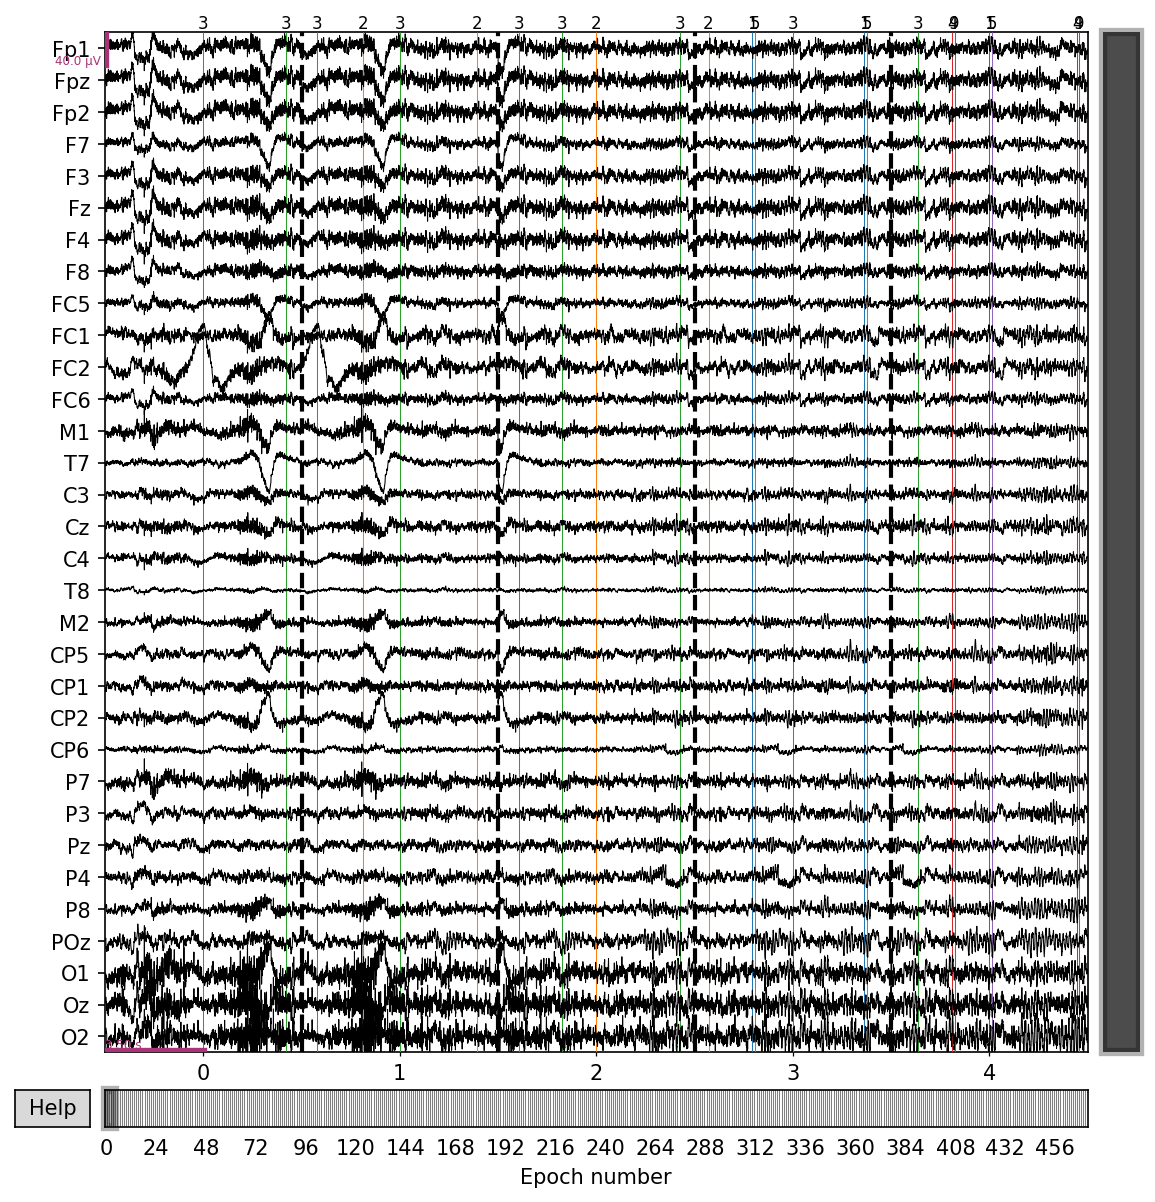

Dropped 146 epochs: 0, 1, 2, 22, 23, 24, 25, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 62, 63, 64, 65, 77, 78, 79, 82, 83, 84, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 112, 113, 114, 134, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 160, 161, 162, 163, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 257, 258, 264, 265, 284, 285, 286, 287, 312, 315, 316, 317, 318, 319, 327, 328, 329, 330, 349, 350, 351, 367, 368, 369, 370, 396, 397, 398, 399, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 433, 434, 435, 436, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 455, 456, 468, 469, 470, 471
The following epochs were marked as bad and are dropped:
[0, 1, 2, 22, 23, 24, 25, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 62, 63, 64, 65, 77, 78, 79, 82, 83, 84, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 112, 113, 114, 134, 135, 136, 139, 140, 141, 142, 143, 144, 

In [ ]:
%matplotlib qt
cleaned_epochs = epochs.copy()

cleaned_epochs.plot(n_epochs=5, n_channels = len(epochs.ch_names), events=True)

In [99]:
cleaned_epochs

<Epochs | 326 events (all good), -3.5 – 3.5 s (baseline off), ~1.18 GB, data loaded, with metadata,
 'GC': 39
 'GF': 38
 'GO': 134
 'GS': 38
 'continue': 39
 'stop': 38>

In [105]:
cleaned_epochs.drop_log_stats

<bound method BaseEpochs.drop_log_stats of <Epochs | 326 events (all good), -3.5 – 3.5 s (baseline off), ~1.18 GB, data loaded, with metadata,
 'GC': 39
 'GF': 38
 'GO': 134
 'GS': 38
 'continue': 39
 'stop': 38>>

# 4. Save epochs back in the source folder

Here I am saving a long version of the epochs to be used for TFR analysis (from -3.5s to +3.5s in my case), and a shorter version to be used for ERP analysis (from -0.5 to +1.5s in my case).

In [111]:
file_epoch = os.path.join(source_path, f"{sub}_cleaned-long-epo.fif")
cleaned_epochs.save(file_epoch, overwrite=True)

In [113]:
cropped_epochs = cleaned_epochs.copy().crop(tmin=-0.5, tmax=1.5)
file_cropped_epoch = os.path.join(source_path, f"{sub}_cleaned-short-epo.fif")
cropped_epochs.save(file_cropped_epoch, overwrite=True)

In [124]:
cropped_epochs.metadata

,event,trial_type,blocks.thisN,trial_loop.thisN,continue_signal_time,stop_signal_time,key_resp_experiment.keys,key_resp_experiment.corr,key_resp_experiment.rt,early_press_resp.keys,early_press_resp.rt,late_key_resp1.keys,late_key_resp1.rt,late_key_resp2.keys,late_key_resp2.rt
3,GO,go_trial,0.0,3.0,NaN,NaN,right,1.0,0.326445,None,NaN,None,NaN,None,NaN
4,GC,go_continue_trial,0.0,4.0,0.10,NaN,right,1.0,0.344450,None,NaN,None,NaN,None,NaN
5,continue,go_continue_trial,0.0,4.0,0.10,NaN,right,1.0,0.344450,None,NaN,None,NaN,None,NaN
6,GS,stop_trial,0.0,5.0,NaN,0.1,right,0.0,0.371032,None,NaN,None,NaN,None,NaN
7,stop,stop_trial,0.0,5.0,NaN,0.1,right,0.0,0.371032,None,NaN,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,continue,go_continue_trial,2.0,113.0,0.05,NaN,right,1.0,0.694208,None,NaN,None,NaN,None,NaN
464,GO,go_trial,2.0,114.0,NaN,NaN,right,1.0,0.599111,None,NaN,None,NaN,None,NaN
465,GS,stop_trial,2.0,115.0,NaN,0.1,right,0.0,0.566018,None,NaN,None,NaN,None,NaN
466,stop,stop_trial,2.0,115.0,NaN,0.1,right,0.0,0.566018,None,NaN,None,NaN,None,NaN


In [130]:
### EXAMPLE USE ###

mask_GO = cropped_epochs.metadata["event"] == "GO"
mask_GF = cropped_epochs.metadata["event"] == "GF"
mask_GS = cropped_epochs.metadata["event"] == "GS"
mask_GC = cropped_epochs.metadata["event"] == "GC"
mask_success = cropped_epochs.metadata["key_resp_experiment.corr"] == 1.0
mask_fail = cropped_epochs.metadata["key_resp_experiment.corr"] == 0.0

go_success = cropped_epochs[mask_GO & mask_success]
go_unsuccess = cropped_epochs[mask_GO & mask_fail]
gf_success = cropped_epochs[mask_GF & mask_success]
gf_unsuccess = cropped_epochs[mask_GF & mask_fail]
gs_success = cropped_epochs[mask_GS & mask_success]
gs_unsuccess = cropped_epochs[mask_GS & mask_fail]
gc_success = cropped_epochs[mask_GC & mask_success]
gc_unsuccess = cropped_epochs[mask_GC & mask_fail]

No projector specified for this dataset. Please consider the method self.add_proj.


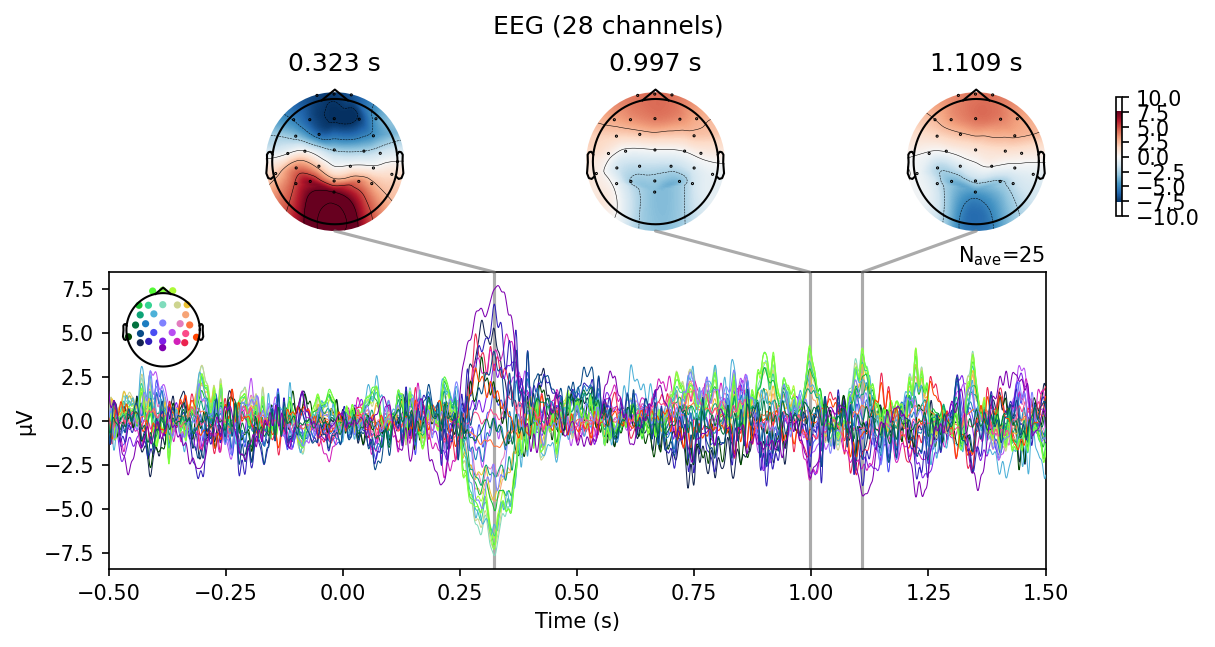

In [131]:
gs_success.average().plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


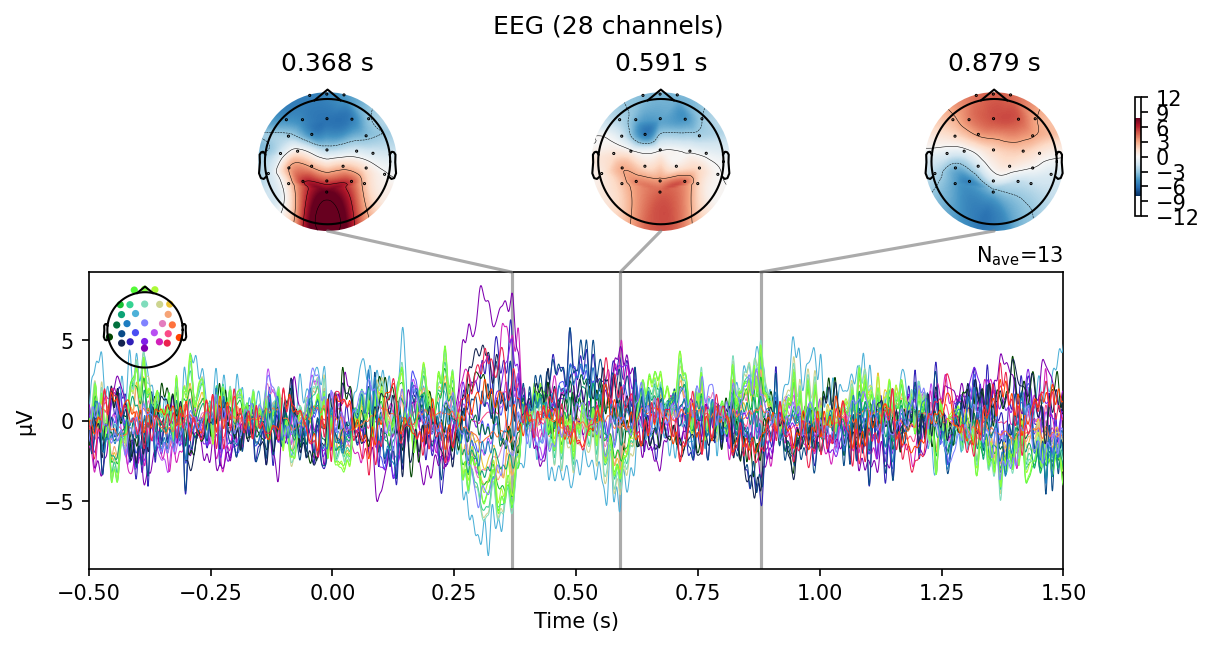

In [132]:
gs_unsuccess.average().plot_joint()

GS unsuccessful Evoked Response


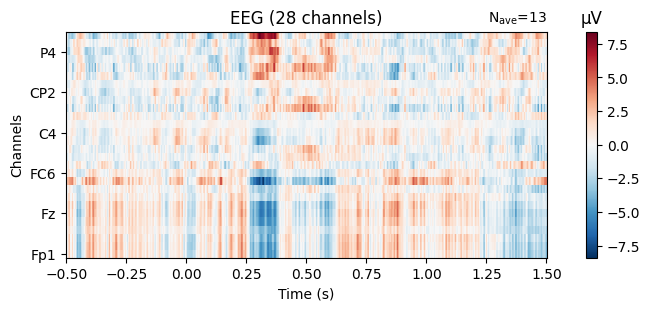

GS successful Evoked Response


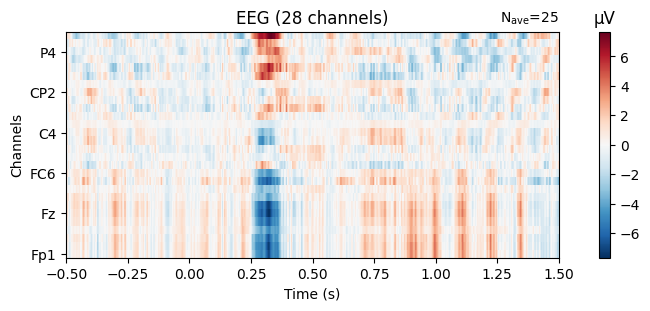

GF successful Evoked Response


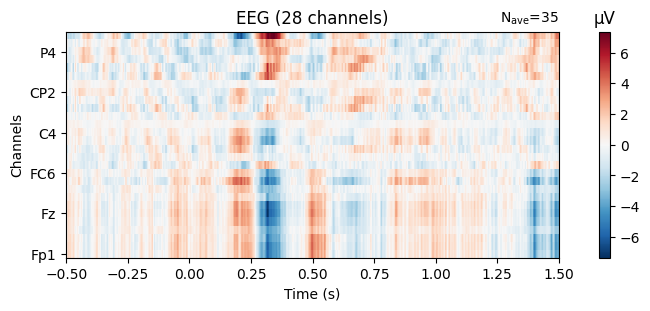

GO successful Evoked Response


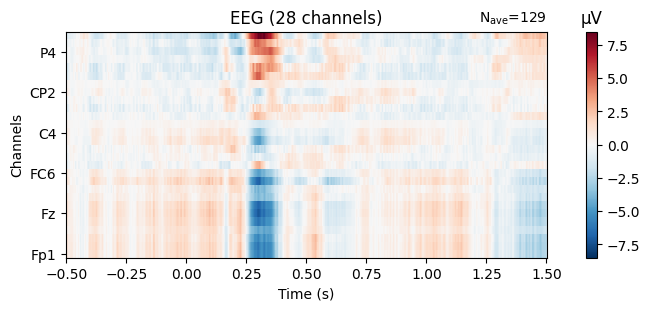

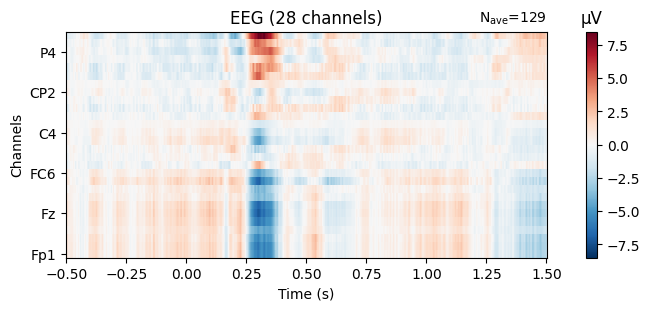

In [151]:
%matplotlib inline
print('GS unsuccessful Evoked Response')
gs_unsuccess.average().plot_image(picks='eeg',
                  #cmap='PuOr',
                  show_names=True
                  )
print('GS successful Evoked Response')
gs_success.average().plot_image(picks='eeg',
                  #cmap='PuOr',
                  show_names=True
                  )
print('GF successful Evoked Response')
gf_success.average().plot_image(picks='eeg',
                  #cmap='PuOr',
                  show_names=True
                  )
print('GO successful Evoked Response')
go_success.average().plot_image(picks='eeg',
                  #cmap='PuOr',
                  show_names=True
                  )


In [160]:
condition_color_dict = dict(
    gs_success="#3ACDDE", gs_unsuccess="#FD548C",
    go_success="#78CD6A", 
    gf_success="#F89E4F",
    gc_success="#160096",
)

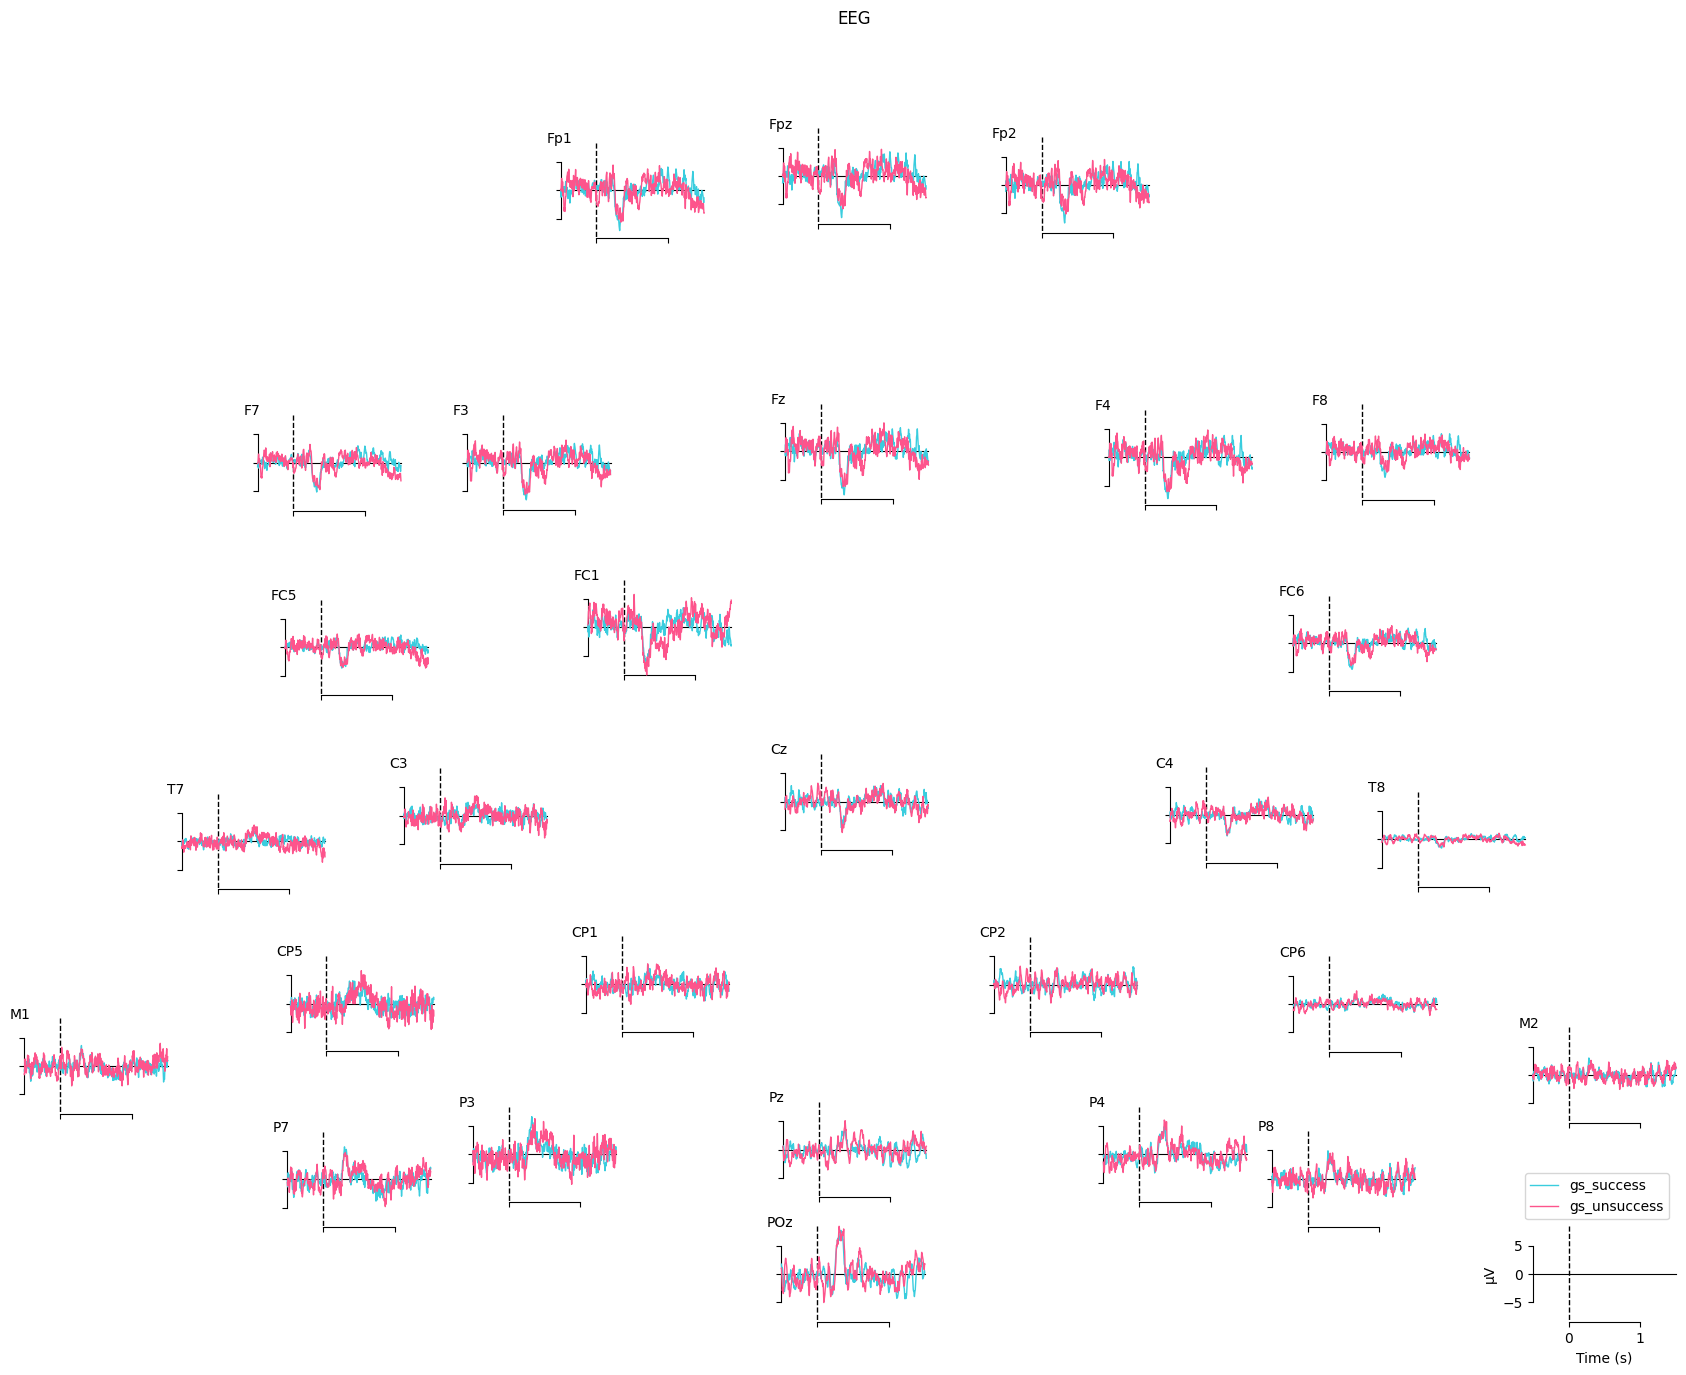

[<Figure size 1800x1400 with 29 Axes>]

In [162]:
%matplotlib inline
# comparison gs_success versus gs_unsuccess
# keep only colors belonging to these conditions:
tiny_dict = dict(
    gs_success=condition_color_dict['gs_success'],
    gs_unsuccess=condition_color_dict['gs_unsuccess']
)
evokeds_gs_success_unsuccess = dict(gs_success=gs_success.average(), gs_unsuccess=gs_unsuccess.average())
mne.viz.plot_compare_evokeds(evokeds_gs_success_unsuccess, 
                             picks='eeg',
                             colors=tiny_dict,
                             axes='topo',
                             styles=dict(gs_success=dict(linewidth=1), 
                                         gs_unsuccess=dict(linewidth=1)))

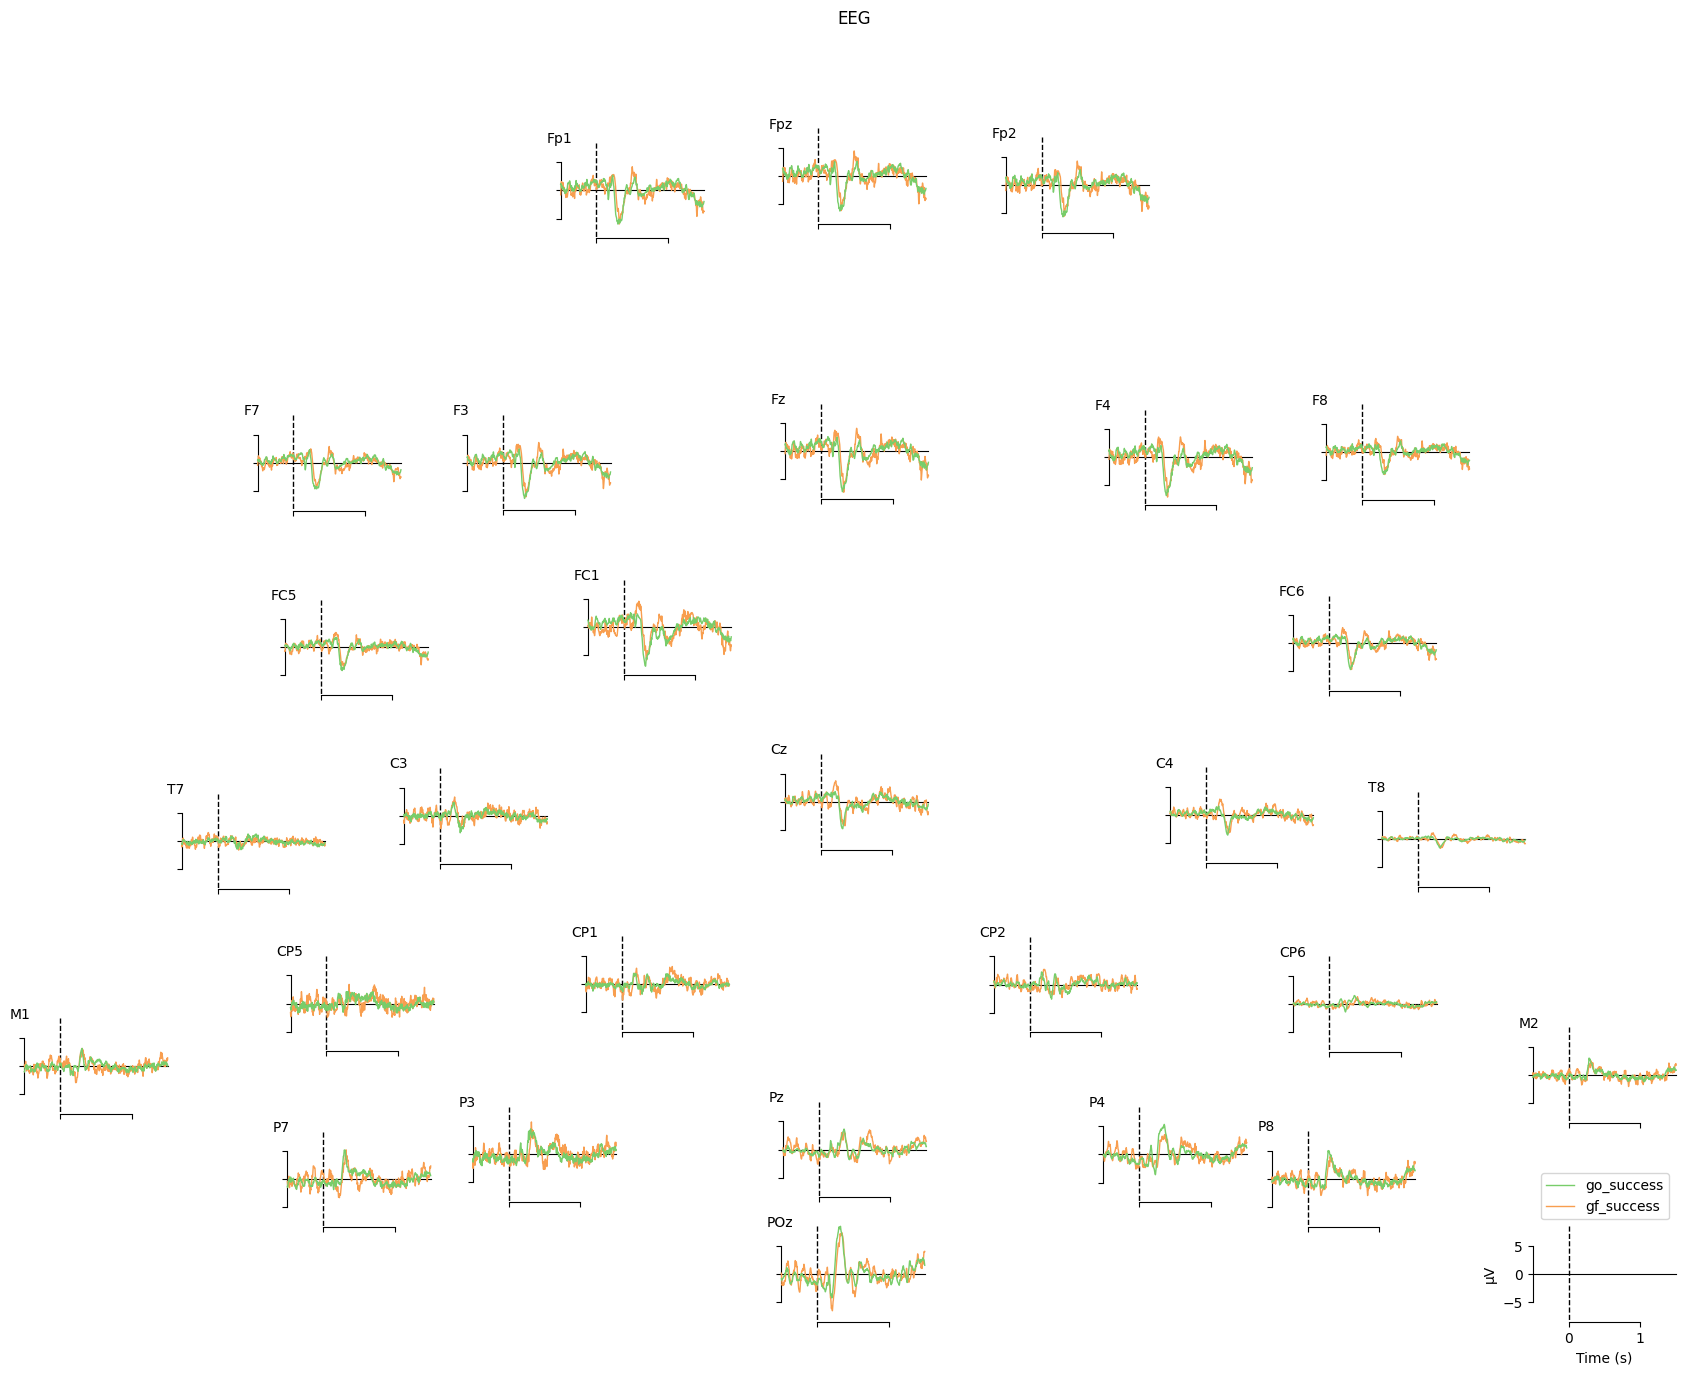

[<Figure size 1800x1400 with 29 Axes>]

In [165]:
%matplotlib inline
# comparison go_success versus gf_success
# keep only colors belonging to these conditions:
tiny_dict = dict(
    go_success=condition_color_dict['go_success'],
    gf_success=condition_color_dict['gf_success']
)
evokeds_gf_success_go_success = dict(gf_success=gf_success.average(), go_success=go_success.average())
mne.viz.plot_compare_evokeds(evokeds_gf_success_go_success, 
                             picks='eeg',
                             colors=tiny_dict,
                             axes='topo',
                             styles=dict(go_success=dict(linewidth=1), 
                                         gf_success=dict(linewidth=1)))

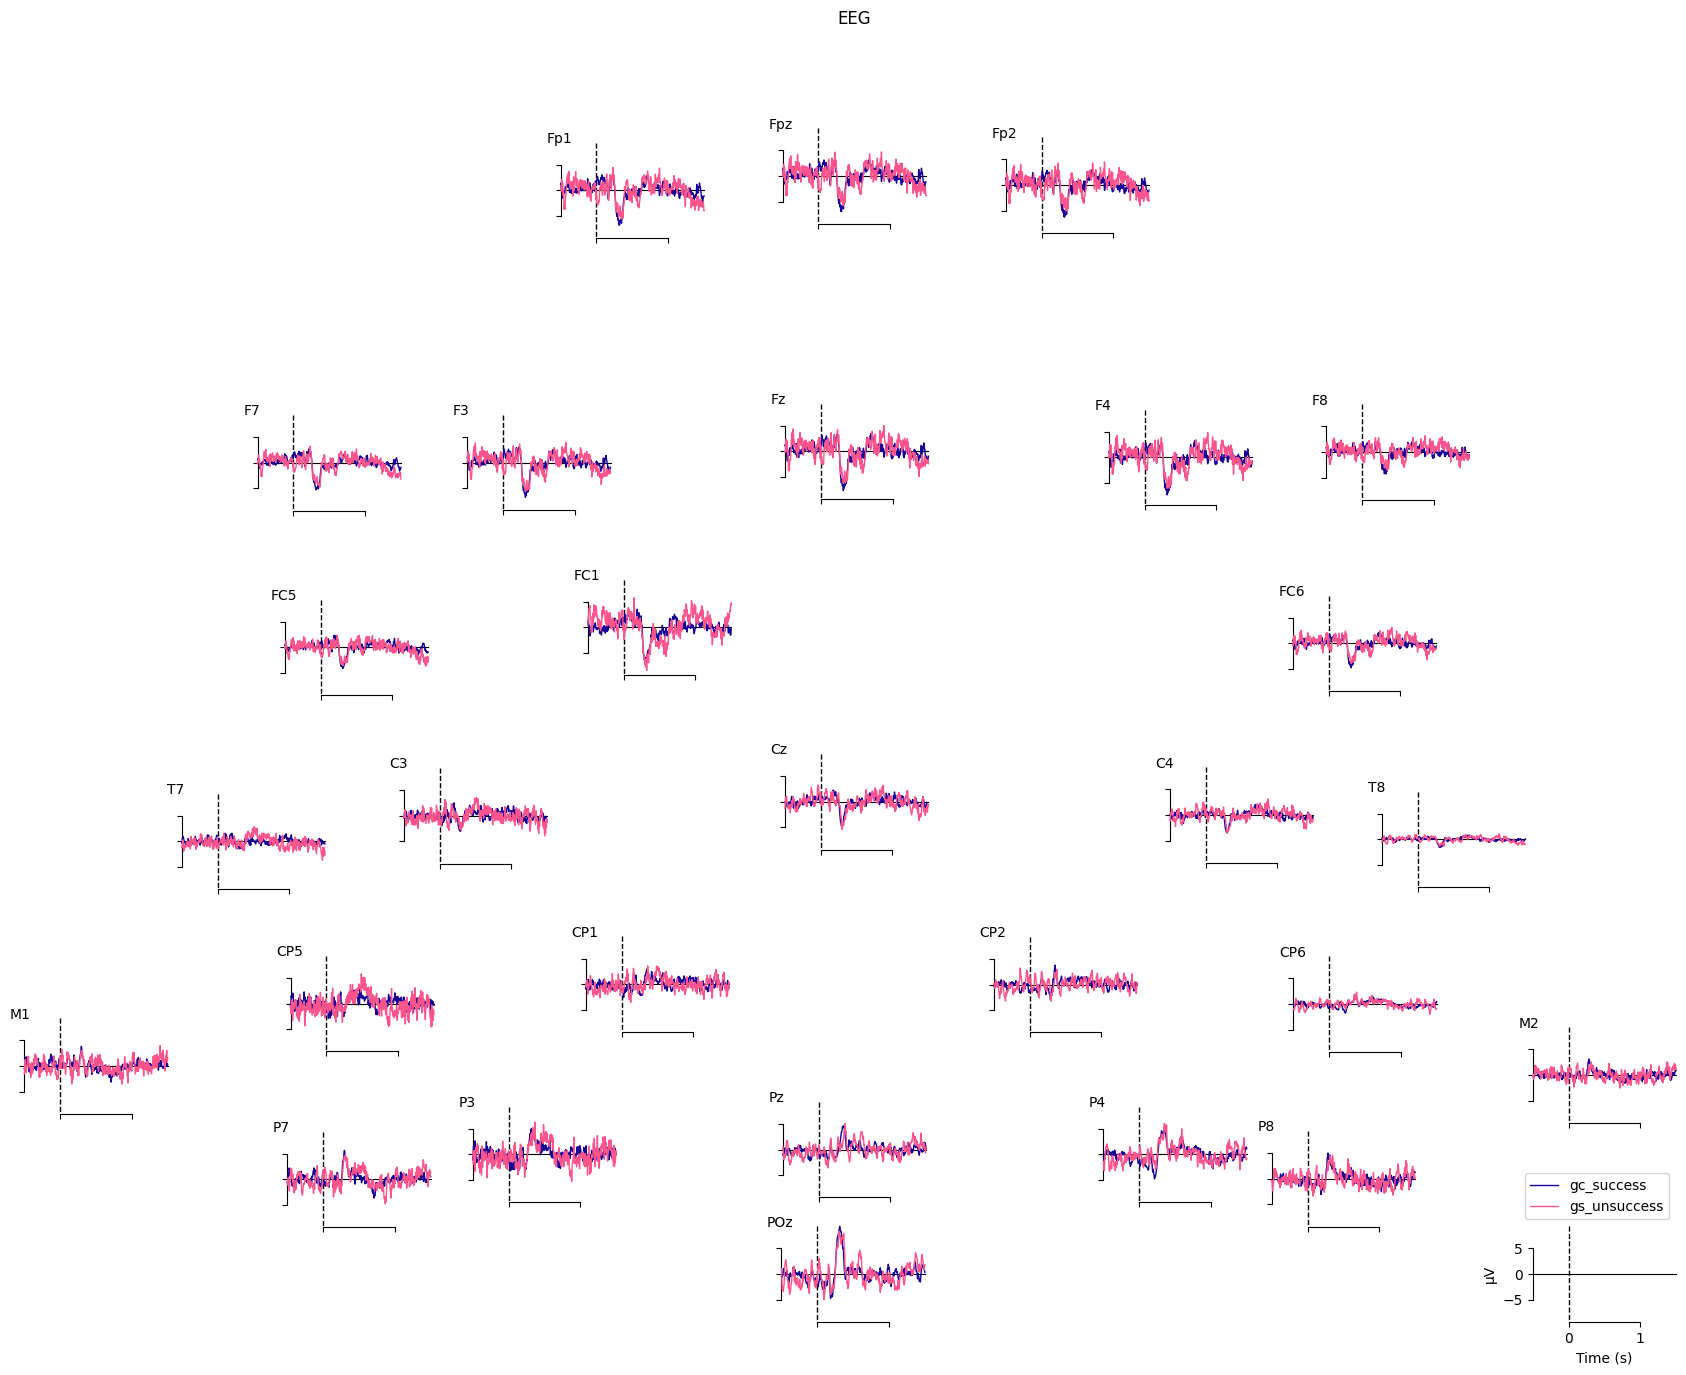

[<Figure size 1800x1400 with 29 Axes>]

In [167]:
%matplotlib inline
# comparison gc_success versus gs_unsuccess
# keep only colors belonging to these conditions:
tiny_dict = dict(
    gc_success=condition_color_dict['gc_success'],
    gs_unsuccess=condition_color_dict['gs_unsuccess']
)
evokeds_gc_success_gs_unsuccess = dict(gc_success=gc_success.average(), gs_unsuccess=gs_unsuccess.average())
mne.viz.plot_compare_evokeds(evokeds_gc_success_gs_unsuccess, 
                             picks='eeg',
                             colors=tiny_dict,
                             axes='topo',
                             styles=dict(gc_success=dict(linewidth=1), 
                                         gs_unsuccess=dict(linewidth=1)))